In [46]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import math
import random
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision
import albumentations
from sklearn import preprocessing

In [49]:
# COMPUTE_CV is only True in the commit phase

COMPUTE_CV = True

# We switch to False if test.csv has more than 3 values
test_data = pd.read_csv(r'test.csv')

if len(test_data)>3: 
    COMPUTE_CV = False

In [42]:
# Parameters

image_size = 24 # Modify to 512
epochs = 1 # Modify to 5



In [1]:
'''from google.colab import drive
drive.mount('/content/drive')'''#For colab

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
#unzipping file
#!unzip /content/drive/MyDrive/Shopee/train_images.zip -d /content/drive/MyDrive/Shopee/ #DONT REUSE

In [3]:
train_csv = pd.read_csv(r'train.csv')

In [68]:
train_csv.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425


In [5]:
#img_temp = Image.open('/content/drive/MyDrive/Shopee/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
img_temp = cv2.imread('train_images/00136d1cf4edede0203f32f05f660588.jpg')



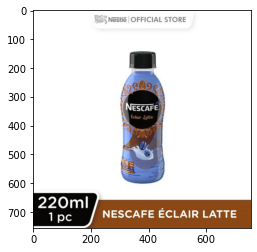

In [6]:
plt.imshow(img_temp)

In [7]:
# Labelencoder for labels
encoder = preprocessing.LabelEncoder()
train_csv['label_group']  = encoder.fit_transform(train_csv['label_group'])


**Targets column**

For each image we add a column containing the posting_id of all images belonging to the same label group


In [81]:
#Creating target column (The ground truth)
tmp = train_csv.groupby('label_group').posting_id.agg('unique')#.to_dict()
train_csv['target'] = train_csv.label_group.map(tmp)

In [94]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]"


In [10]:
# Number of labels
n_labels = max(train_csv["label_group"])+1
print(n_labels)

11014


**Baseline model score**

The baseline model is a model that predicts two matching products if they have the same hash

In [104]:
# Calculating score of baseline model

tmp = train_csv.groupby('image_phash').posting_id.agg('unique').to_dict()
train_csv['base_predictions'] = train_csv.image_phash.map(tmp)

# From Chris notebook
def getMetric(col):
    def f1score(row):
        n = len(np.intersect1d(row.target,row[col]))
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

train_csv['f1'] = train_csv.apply(getMetric('base_predictions'), axis=1)

In [107]:
# F1 score of our base model 
train_csv['f1'].mean()

0.5530933399168149

In [109]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,target,base_p,base_predictions,f1
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",[train_129225211],[train_129225211],0.666667
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",[train_3386243561],[train_3386243561],0.666667
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]",[train_2288590299],[train_2288590299],0.666667
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]",[train_2406599165],[train_2406599165],0.666667
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]",[train_3369186413],[train_3369186413],0.666667


In [110]:
train_csv = train_csv.drop('f1', axis=1)

In [115]:
# Data augmentation

transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
                                           albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
                                           albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
                                           albumentations.CoarseDropout(p=0.5),
                                           albumentations.Normalize()])

In [125]:
# Createing dataset
class ShopeeDataset(Dataset):
    def __init__(self, csv, transforms=None, imsize = 512):
        self.csv = csv
        self.transforms = transforms
        self.imsize = imsize
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        title = row.title
        img = cv2.imread('train_images/'+row.image)
        if self.transforms != None:
          img = self.transforms(image = img)['image']
        img= transforms.ToTensor()(img)
        
        img = transforms.Resize((self.imsize,self.imsize))(img)
        #img = img.unsqueeze(dim = 0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img,torch.tensor(row.label_group)

In [16]:
# Defining dataset
ds = ShopeeDataset(train_csv, imsize= 24)

In [17]:
len(ds)

34250

In [18]:
ds[0][0].size()

torch.Size([3, 24, 24])

In [19]:
# Defining train loader
train_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=120,
        pin_memory=True,
        drop_last=True
    )

torch.Size([120, 3, 24, 24])
tensor([  666,  7572,  6172, 10509,  9425,  6836,  4687,  3976,  6076,  6754,
         6347,  1306,  1306, 10797,  4940,   897,  4002,  6058,  8795,  5382,
         9363,  1363, 10874,  5732, 10391,  1039,  5192,  7555,  1366,  1366,
         2333,  6351, 10937,  9246, 10069,  4148,  6817,  8584,  9843,  2575,
         3012,   260,  2466,  2512,  2719,  5085,  3907,  9392,  3280,  4728,
         2994,  7285,   947,  3529,  5705,  7647,  3499,  3499,   561,   561,
         2119,  3128,   510,  9011,  3970,  9251,  4355,  2038,  5853,  9794,
          919,  9830,   383,  2922, 10577,  9011,  3203,  2569,  4839,  2072,
         6861,  8675, 10643,  2787,  9251,  2994,  3466,  4812,  8510,  6222,
         8036,  8720,  6951,  2102,  2930,  3096,  4472,  2994,  9011,  9011,
         7975,  3646, 10629,  4538,  2716,  2716,  2716,  2716,  8785,  8785,
          909,  9364,  5191,  4849,  3250,   316,  6806,  9518, 10730,   950])


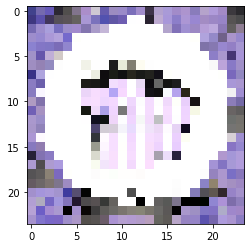

In [20]:
for x,y in train_loader:
  print(x.size())
  plt.imshow(transforms.ToPILImage()(x[0]))
  break

In [126]:
#Dataset using augmented data
ds_augmentee = ShopeeDataset(train_csv, imsize= 24, transforms=transforms_train)

In [127]:
ds_augmentee[0][0].size()

torch.Size([3, 24, 24])

In [128]:
train_loader_augmentee =torch.utils.data.DataLoader(
        ds_augmentee,
        batch_size=120,
        pin_memory=True,
        drop_last=True
    )

torch.Size([120, 3, 24, 24])


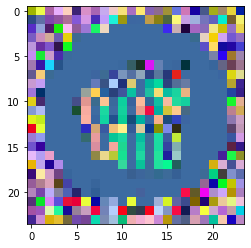

In [129]:
for x,y in train_loader_augmentee:
  print(x.size())
  plt.imshow(transforms.ToPILImage()(x[0]))
  break

In [21]:
# Random network just for test
class RandNet(nn.Module):
    def __init__(self, n_classes, fc_dim = 24):
        super(RandNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size = 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.layers = nn.Sequential(self.conv1, nn.ReLU(), self.maxpool)
        self.final_layer = nn.Linear(4*12*12, n_classes)
        
    def embedding(self, x):
        vector = self.layers(x)
        #vector = self.maxpool(vector)
        return (vector)
    
    def forward(self,x):
        z = self.embedding(x)
        z= z.view(-1,4*12*12)
        return self.final_layer(z)
        

In [22]:
rdn = RandNet(n_labels)

In [24]:
for x,y in train_loader:
  print(x.size())
  print(y)
  print(rdn(x))
  break

torch.Size([120, 3, 24, 24])
tensor([  666,  7572,  6172, 10509,  9425,  6836,  4687,  3976,  6076,  6754,
         6347,  1306,  1306, 10797,  4940,   897,  4002,  6058,  8795,  5382,
         9363,  1363, 10874,  5732, 10391,  1039,  5192,  7555,  1366,  1366,
         2333,  6351, 10937,  9246, 10069,  4148,  6817,  8584,  9843,  2575,
         3012,   260,  2466,  2512,  2719,  5085,  3907,  9392,  3280,  4728,
         2994,  7285,   947,  3529,  5705,  7647,  3499,  3499,   561,   561,
         2119,  3128,   510,  9011,  3970,  9251,  4355,  2038,  5853,  9794,
          919,  9830,   383,  2922, 10577,  9011,  3203,  2569,  4839,  2072,
         6861,  8675, 10643,  2787,  9251,  2994,  3466,  4812,  8510,  6222,
         8036,  8720,  6951,  2102,  2930,  3096,  4472,  2994,  9011,  9011,
         7975,  3646, 10629,  4538,  2716,  2716,  2716,  2716,  8785,  8785,
          909,  9364,  5191,  4849,  3250,   316,  6806,  9518, 10730,   950])
tensor([[-0.0887,  0.3042, -0.0519

In [25]:
# Average
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
from time import time

In [41]:
#Training
def train_fn(dataloader, model, criterion, optimizer, epoch):
    model.train()
    loss_score = AverageMeter()
    t = time()
    tot = len(dataloader)
    #for i,d in tqdm(enumerate(dataloader), total=tot):
    i = 0
    for images,targets in tqdm(dataloader, total=tot):
        batch_size = targets.shape[0]
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,targets)
        loss.backward()
        optimizer.step()
        loss_score.update(loss.detach().item(), batch_size)
        #tk0.set_postfix(Train_Loss=loss_score.avg,Epoch=epoch,LR=optimizer.param_groups[0]['lr'])
        
    return loss_score

In [36]:
optimizer = torch.optim.Adam(rdn.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()
                             

In [43]:
train_fn(train_loader, rdn, loss, optimizer, 1)

  2%|▏         | 6/285 [00:10<08:00,  1.72s/it]


KeyboardInterrupt: 

**TO DO :**
- F1 score and evaluation of baseline ✅ 
- Data augmentation ✅ 
- Arcface metric implementation
- Transfer training using some model like effnet
- Creating embedding using the model 
- Implementing knn to determine the predictions
- CV score and evaluation of model predictions
- Modify code to use cuda



**Notes** 

The goal of the loss function is to minimize the maximum intra-class distance while keeping the features of different classes separable. Chosing the right loss function that can enhance the discrimnative power is key to our problem.